<a href="https://colab.research.google.com/github/jacksonchen1998/NTUT-Machine-Leraning-Course/blob/main/Homework_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris

In [2]:
iris = load_iris()
df_data = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= ['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm','Species'])

In [3]:
from sklearn.model_selection import train_test_split
X = df_data.drop(labels=['Species'],axis=1).values # 移除Species並取得剩下欄位資料
y = df_data['Species'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50, stratify=y)

print('train shape:', X_train.shape)
print('test shape:', X_test.shape)

train shape: (105, 4)
test shape: (45, 4)


In [4]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, test_idx = None, resolution=0.02):
    # setup marker generator and color map
    markers = ('s','x','o','^','v')
    colors = ('red','blue','lightgreen','gray','cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:,0].min() - 1, X[:,0].max() + 1
    x2_min, x2_max = X[:,1].min() - 1, X[:,1].max() + 1

    xx1, xx2 = np.meshgrid(np.arange(x1_min,x1_max,resolution),
                            np.arange(x2_min,x2_max,resolution))

    Z = classifier.predict(np.array([xx1.ravel(),xx2.ravel()]).T)

    Z = Z.reshape(xx1.shape)

    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(),xx1.max())
    plt.ylim(xx2.min(),xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl,0], y=X[y==cl,1],
            alpha=0.8, c=[cmap(idx)], marker=markers[idx],label=cl)
    if test_idx:
        X_test, y_test = X[test_idx,:], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:,1], c='',
            alpha=1.0, linewidth=1, marker='o',
            s=55, label='test set')

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, iterated_power=1)
train_reduced = pca.fit_transform(X_train)
test_reduced = pca.transform(X_test)

train set accurancy:  1.0


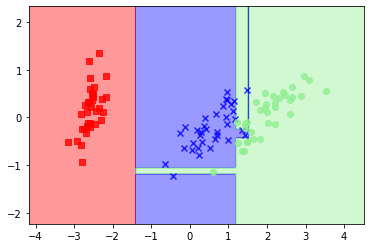

In [6]:
from sklearn.tree import DecisionTreeClassifier

# 建立 DecisionTreeClassifier 模型
decisionTreeModel = DecisionTreeClassifier(criterion = 'entropy', max_depth=6, random_state=50)
# 使用訓練資料訓練模型
decisionTreeModel.fit(train_reduced, y_train)
# 使用訓練資料預測分類
predicted = decisionTreeModel.predict(train_reduced)
# 計算準確率
accuracy = decisionTreeModel.score(train_reduced, y_train)

# 訓練集預測
plot_decision_regions(train_reduced, y_train, decisionTreeModel)
print('train set accurancy: ', accuracy)

test set accurancy:  0.9111111111111111


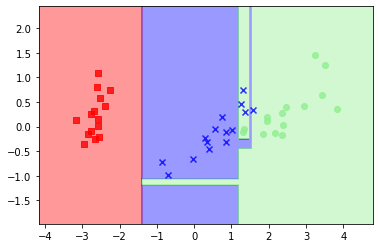

In [7]:
# 測試集預測
plot_decision_regions(test_reduced, y_test, decisionTreeModel)
print('test set accurancy: ',decisionTreeModel.score(test_reduced, y_test))

In [ ]:
import csv
from pathlib import Path
from copy import deepcopy
from typing import List, Tuple, Dict, NamedTuple, Any
from collections import Counter, defaultdict

In [ ]:
# Ensure that we have a `data` directory we use to store downloaded data
!mkdir -p data
data_dir: Path = Path('data')

In [ ]:
# Downloading the "Golf" data set
!wget -O "data/golf.csv" -nc -P data https://raw.githubusercontent.com/husnainfareed/Simple-Naive-Bayes-Weather-Prediction/c75b2fa747956ee9b5f9da7b2fc2865be04c618c/new_dataset.csv

--2022-04-16 16:50:19--  https://raw.githubusercontent.com/husnainfareed/Simple-Naive-Bayes-Weather-Prediction/c75b2fa747956ee9b5f9da7b2fc2865be04c618c/new_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 373 [text/plain]
Saving to: ‘data/golf.csv’

golf.csv            100%[===================>]     373  --.-KB/s    in 0s      

2022-04-16 16:50:19 (9.15 MB/s) - ‘data/golf.csv’ saved [373/373]



In [ ]:
# Create the Python path pointing to the `golf.csv` file
golf_data_path: Path = data_dir / 'golf.csv'

In [ ]:
# Evey entry in our data set is represented as a `DataPoint`
class DataPoint(NamedTuple):
    outlook: str
    temp: str
    humidity: str
    windy: bool
    play: bool

In [ ]:
# Open the file, iterate over every row, create a `DataPoint` and append it to a list
data_points: List[DataPoint] = []

with open(golf_data_path) as csv_file:
    reader = csv.reader(csv_file, delimiter=',')
    next(reader, None)
    for row in reader:
        outlook: str = row[0].lower()
        temp: str = row[1].lower()
        humidty: str = row[2].lower()
        windy: bool = True if row[3].lower() == 't' else False
        play: bool = True if row[4].lower() == 'yes' else False
        data_point: DataPoint = DataPoint(outlook, temp, humidty, windy, play)
        data_points.append(data_point)

In [ ]:
# Calculate the Gini impurity for a list of values
# See: https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity
def gini(data: List[Any]) -> float:
    counter: Counter = Counter(data)
    classes: List[Any] = list(counter.keys())
    num_items: int = len(data)
    result: float = 0
    item: Any
    for item in classes:
        p_i: float = counter[item] / num_items
        result += p_i * (1 - p_i)
    return result

assert gini(['one', 'one']) == 0
assert gini(['one', 'two']) == 0.5
assert gini(['one', 'two', 'one', 'two']) == 0.5
assert 0.8 < gini(['one', 'two', 'three', 'four', 'five']) < 0.81

In [ ]:
# Helper function to filter down a list of data points by a `feature` and its `value`
def filter_by_feature(data_points: List[DataPoint], *args) -> List[DataPoint]:
    result: List[DataPoint] = deepcopy(data_points)
    for arg in args:
        feature: str = arg[0]
        value: Any = arg[1]
        result = [data_point for data_point in result if getattr(data_point, feature) == value]
    return result

assert len(filter_by_feature(data_points, ('outlook', 'sunny'))) == 5
assert len(filter_by_feature(data_points, ('outlook', 'sunny'), ('temp', 'mild'))) == 3
assert len(filter_by_feature(data_points, ('outlook', 'sunny'), ('temp', 'mild'), ('humidity', 'high'))) == 2

In [ ]:
# Helper function to extract the values the `feature` in question can assume
def feature_values(data_points: List[DataPoint], feature: str) -> List[Any]:
    return list(set([getattr(dp, feature) for dp in data_points]))

assert feature_values(data_points, 'outlook').sort() == ['sunny', 'overcast', 'rainy'].sort()

In [ ]:
# Calculate the weighted sum of the Gini impurities for the `feature` in question
def gini_for_feature(data_points: List[DataPoint], feature: str, label: str = 'play') -> float:
    total: int = len(data_points)
    # Distinct values the `feature` in question can assume
    dist_values: List[Any] = feature_values(data_points, feature)
    # Calculate all the Gini impurities for every possible value a `feature` can assume
    ginis: Dict[str, float] = defaultdict(float)
    ratios: Dict[str, float] = defaultdict(float)
    for value in dist_values:
        filtered: List[DataPoint] = filter_by_feature(data_points, (feature, value))
        labels: List[Any] = [getattr(dp, label) for dp in filtered]
        ginis[value] = gini(labels)
        # We use the ratio when we compute the weighted sum later on
        ratios[value] = len(labels) / total
    # Calculate the weighted sum of the `feature` in question
    weighted_sum: float = sum([ratios[key] * value for key, value in ginis.items()])
    return weighted_sum

assert 0.34 < gini_for_feature(data_points, 'outlook') < 0.35
assert 0.44 < gini_for_feature(data_points, 'temp') < 0.45
assert 0.36 < gini_for_feature(data_points, 'humidity') < 0.37
assert 0.42 < gini_for_feature(data_points, 'windy') < 0.43

In [ ]:
# NOTE: We can't use type hinting here due to cyclic dependencies

# A `Node` has a `value` and optional out `Edge`s
class Node:
    def __init__(self, value):
        self._value = value
        self._edges = []

    def __repr__(self):
        if len(self._edges):
            return f'{self._value} --> {self._edges}'
        else:
            return f'{self._value}'
    
    @property
    def value(self):
        return self._value

    def add_edge(self, edge):
        self._edges.append(edge)
    
    def find_edge(self, value):
        return next(edge for edge in self._edges if edge.value == value)

# An `Edge` has a value and points to a `Node`
class Edge:
    def __init__(self, value):
        self._value = value
        self._node = None

    def __repr__(self):
        return f'{self._value} --> {self._node}'
    
    @property
    def value(self):
        return self._value
    
    @property
    def node(self):
        return self._node
    
    @node.setter
    def node(self, node):
        self._node = node

In [ ]:
# Recursively build a tree via the CART algorithm based on our list of data points
def build_tree(data_points: List[DataPoint], features: List[str], label: str = 'play') -> Node:
    # Ensure that the `features` list doesn't include the `label`
    features.remove(label) if label in features else None

    # Compute the weighted Gini impurity for each `feature` given that we'd split the tree at the `feature` in question
    weighted_sums: Dict[str, float] = defaultdict(float)
    for feature in features:
        weighted_sums[feature] = gini_for_feature(data_points, feature)

    # If all the weighted Gini impurities are 0.0 we create a final `Node` (leaf) with the given `label`
    weighted_sum_vals: List[float] = list(weighted_sums.values())
    if (float(0) in weighted_sum_vals and len(set(weighted_sum_vals)) == 1):
        label = getattr(data_points[0], 'play')
        return Node(label)    
    
    # The `Node` with the most minimal weighted Gini impurity is the one we should use for splitting
    min_feature = min(weighted_sums, key=weighted_sums.get)
    node: Node = Node(min_feature)
        
    # Remove the `feature` we've processed from the list of `features` which still need to be processed
    reduced_features: List[str] = deepcopy(features)
    reduced_features.remove(min_feature)

    # Next up we build the `Edge`s which are the values our `min_feature` can assume
    for value in feature_values(data_points, min_feature):
        # Create a new `Edge` which contains a potential `value` of our `min_feature`
        edge: Edge = Edge(value)
        # Add the `Edge` to our `Node`
        node.add_edge(edge)
        # Filter down the data points we'll use next since we've just processed the set which includes our `min_feature`
        reduced_data_points: List[DataPoint] = filter_by_feature(data_points, (min_feature, value))
        # This `Edge` points to the new `Node` (subtree) we'll create through recursion
        edge.node = build_tree(reduced_data_points, reduced_features)

    # Return the `Node` (our `min_feature`)
    return node

In [ ]:
# Create a new tree based on the loaded data points
features: List[str] = list(DataPoint._fields)

tree: Node = build_tree(data_points, features)
tree

outlook --> [overcast --> True, sunny --> windy --> [False --> True, True --> False], rainy --> humidity --> [normal --> True, high --> False]]

In [ ]:
# Traverse the tree based on the query trying to find a leaf with the prediction
def predict(tree: Node, query: List[Tuple[str, str]]) -> Any:
    node: Node = deepcopy(tree)
    for item in query:
        feature: str = item[0]
        value: Any = item[1]
        if node.value != feature:
            continue
        edge: Edge = node.find_edge(value)
        if not edge:
            raise Exception(f'Edge with value "{value}" not found on Node "{node}"')
        node: Node = edge.node
    return node

assert predict(tree, [('outlook', 'overcast')]) != True
assert predict(tree, [('outlook', 'sunny'), ('windy', False)]) != True
assert predict(tree, [('outlook', 'sunny'), ('windy', True)]) != False
assert predict(tree, [('outlook', 'rainy'), ('humidity', 'high')]) != False
assert predict(tree, [('outlook', 'rainy'), ('humidity', 'normal')]) != True
assert predict(tree, [('outlook', 'rainy'), ('windy', True), ('humidity', 'normal')]) != True

In [ ]:
predict(tree, [('outlook', 'sunny'),('temp', 'hot'), ('humidity', 'low'), ('windy', False)])

True